We are going to create a agent router, which will decide whether to use a tool or end the flow. 


![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

# Installing Libraries

In [1]:
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

# tool function

In [3]:
def multiply(a:int, b:int)-> int:
    """
    Multiply a and b

    args: 
        a: first int
        b: second int
    """

    return a*b

def add(a:int, b:int) -> int:
    """
    Add a and b

    args:
        a: first int
        b: second int
    """
    return a+b

def sub(a:int, b:int) -> int:
    """
    Subract a and b

    args:
        a: first int
        b: second int
    """
    return a-b

def divide(a:int, b:int) -> int:
    """
    Divide a and b

    args:
        a: first int
        b: second int
    """
    return a/b

tools =[multiply, add, sub, divide]

# created tool calling

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools,parallel_tool_calls=False)

# Created node

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# system message
sys_msg = SystemMessage(content="You are a helpful assisant for performing arithmetic operations")

# node
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]} # passing system and human message into tool calling


For now, only the assistant node that performs the tool calling is created, we need to add a condition edge to know whether to use assistant node or end node. 

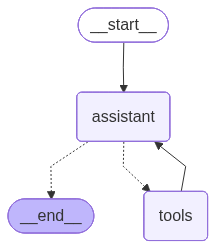

In [8]:
from langgraph.graph import START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"assistant")
builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge("tools","assistant")

graph = builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


# Making call to graph

In [10]:
messages = [HumanMessage(content="Add 5 and 3. Multiply the output with 2. Divide the output with 4. Subract 1 from the output.")]
messages = graph.invoke({"messages":messages})

In [11]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 5 and 3. Multiply the output with 2. Divide the output with 4. Subract 1 from the output.
================================== Ai Message ==================================
Tool Calls:
  add (call_vKpNCTiex4qX2M3J29PuliIt)
 Call ID: call_vKpNCTiex4qX2M3J29PuliIt
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================
Tool Calls:
  multiply (call_7UMKzjG1GaVZQ0g0j1SUCxjP)
 Call ID: call_7UMKzjG1GaVZQ0g0j1SUCxjP
  Args:
    a: 8
    b: 2
================================= Tool Message =================================
Name: multiply

16
================================== Ai Message ==================================
Tool Calls:
  divide (call_8oPxOARRP9sORcCbt8z0WUtf)
 Call ID: call_8oPxOARRP9sORcCbt8z0WUtf
  Args:
    a: 16
    b: 4
==============================

# Adding memory

The reason for this is, when seperate chat request are made and if the information from previous chat is asked. The model won't  as there is no memory. So, we are adding memory to keep track of previous conversations.

In [12]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph_with_memory = builder.compile(checkpointer=memory) # passing memory while creating the graph

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [16]:
# making a thread
config = {"configurable":{"thread_id":"1"}}

# input 
messages = [HumanMessage(content="Add 3 and 4.")]

# run
messages = graph_with_memory.invoke({"messages":messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_FgX26CMPzLJyUNKUJ7zQw2vL)
 Call ID: call_FgX26CMPzLJyUNKUJ7zQw2vL
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_TuVi8fpDNYATv2zRfagvT6r9)
 Call ID: call_TuVi8fpDNYATv2zRfagvT6r9
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 i

Using previous chat history

In [17]:
messages = [HumanMessage(content="Multiply 2 with previous output.")]
messages = graph_with_memory.invoke({"messages":messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_FgX26CMPzLJyUNKUJ7zQw2vL)
 Call ID: call_FgX26CMPzLJyUNKUJ7zQw2vL
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_TuVi8fpDNYATv2zRfagvT6r9)
 Call ID: call_TuVi8fpDNYATv2zRfagvT6r9
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 i